In [1]:
import re
import cv2
import numpy as np
import os
import pytesseract
from PIL import Image
from pytesseract import Output
from matplotlib import pyplot as plt
import json
import sys
import pandas as pd

In [2]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

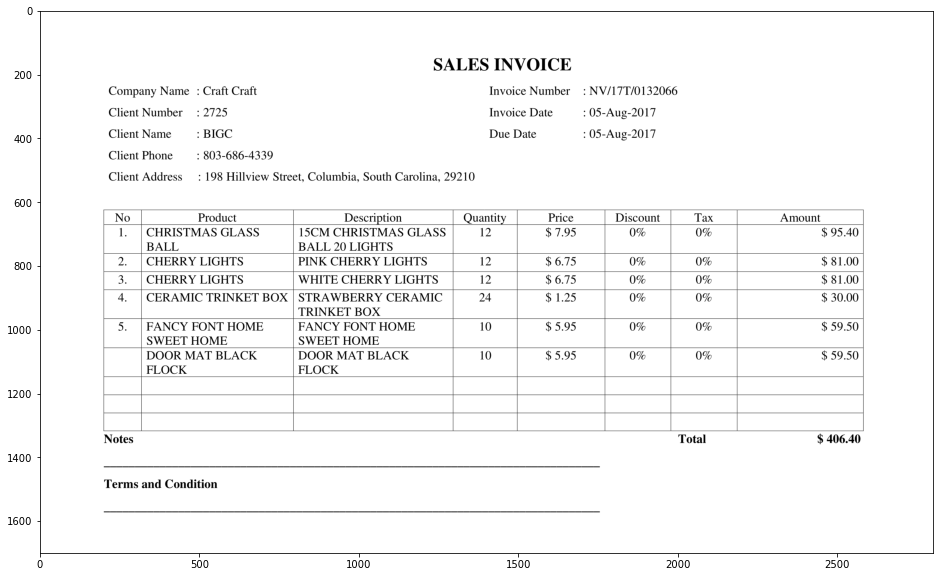

In [3]:
img = cv2.imread(r"E:\Koding\Python\Kerja\KTP-OCR\Dataset\Invoice\SALES INVOICE 1-1.png",0)

plt.figure(figsize=(16,12))
plotting = plt.imshow(img,cmap='gray')
plt.show()

In [4]:
txt = pytesseract.image_to_string(img, lang="ind")
print(txt)

SALES INVOICE

Company Name : Craft Craft Invoice Number : NV/17T/0132066
Client Number :2725 Invoice Date : 05-Aug-2017
Client Name : BIGC Due Date : 05-Aug-2017

Client Phone : 803-686-4339
Client Address : 198 Hillview Street, Columbia, South Carolina, 29210

No Product Description Ouantity Price Discount Tax Amount
1. . CHRISTMAS GLASS 15CM CHRISTMAS GLASS 12 $ 7.95 090 090 $ 95.40
BALL BALL 20 LIGHTS
. | CHERRY LIGHTS PINK CHERRY LIGHTS 12 $ 6.75 090 090 $ 81.00
3. | CHERRY LIGHTS WHITE CHERRY LIGHTS 12 $ 6.75 090 090 $ 81.00
CERAMIC TRINKET BOX | STRAWBERRY CERAMIC 24 $1.25 090 090 $ 30.00
TRINKET BOX
5. . FANCY FONT HOME FANCY FONT HOME 10 $ 5.95 090 090 $ 59.50
SWEET HOME SWEET HOME
DOOR MAT BLACK DOOR MAT BLACK 10 $ 5.95 090 090 $ 59.50
FLOCK FLOCK
Notes Total $ 406.40

Terms and Condition



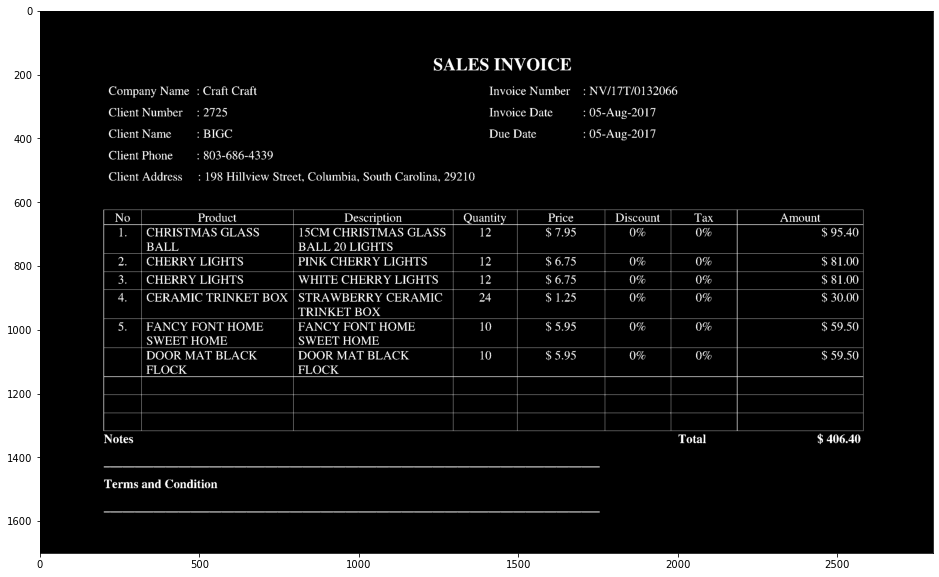

In [5]:
#thresholding the image to a binary image
thresh,img_bin = cv2.threshold(img,128,255,cv2.THRESH_BINARY |cv2.THRESH_OTSU)
#inverting the image 
img_bin = 255-img_bin
#Plotting the image to see the output
plt.figure(figsize=(16,12))
plotting = plt.imshow(img_bin,cmap='gray')
plt.show()

In [6]:
# Length(width) of kernel as 100th of total width
kernel_len = np.array(img).shape[1]//100
# Defining a vertical kernel to detect all vertical lines of image 
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
# Defining a horizontal kernel to detect all horizontal lines of image
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
# A kernel of 2x2
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

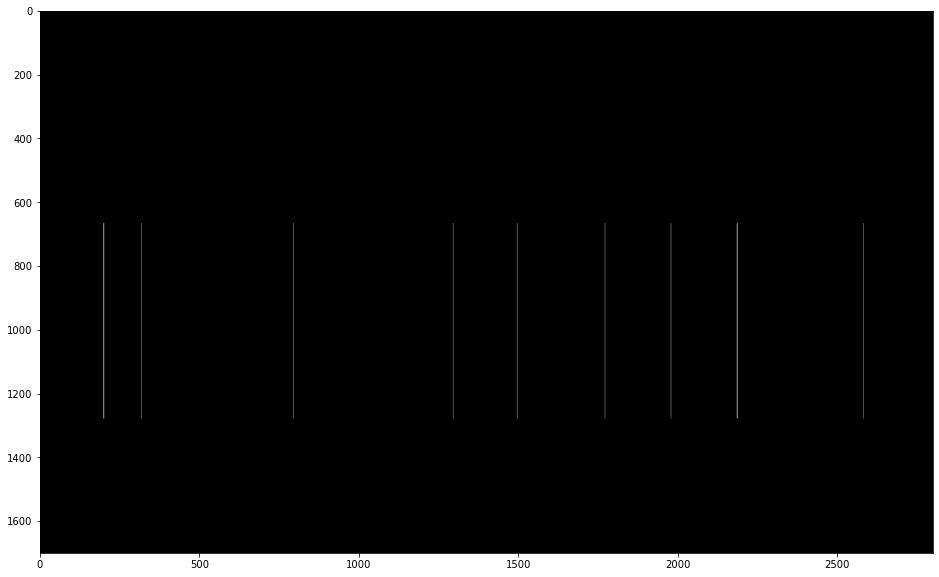

In [7]:
#Use vertical kernel to detect and save the vertical lines in a jpg
image_1 = cv2.erode(img_bin, ver_kernel, iterations=3)
vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)
#Plot the generated image
plt.figure(figsize=(16,12))
plotting = plt.imshow(image_1,cmap='gray')
plt.show()

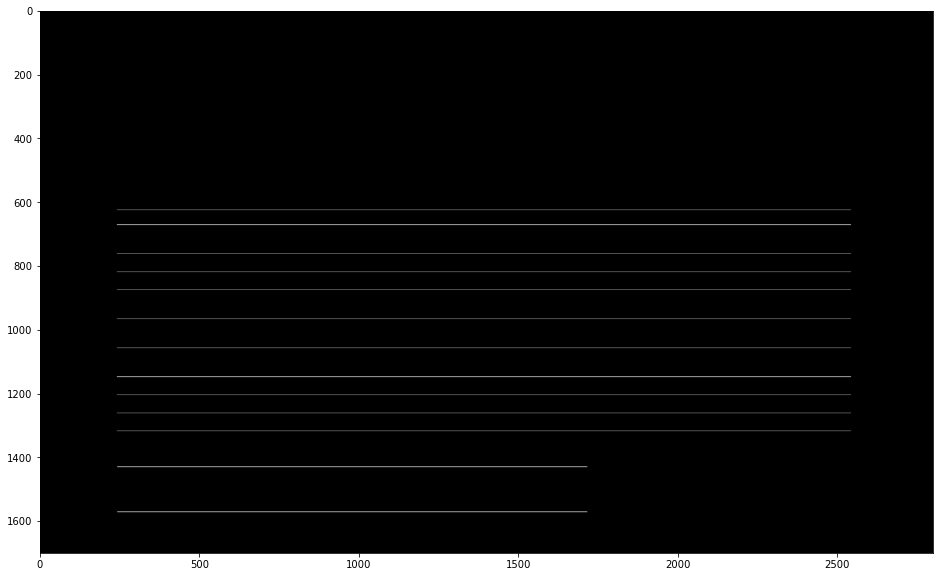

In [8]:
#Use horizontal kernel to detect and save the horizontal lines in a jpg
image_2 = cv2.erode(img_bin, hor_kernel, iterations=3)
horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)
#Plot the generated image
plt.figure(figsize=(16,12))
plotting = plt.imshow(image_2,cmap='gray')
plt.show()

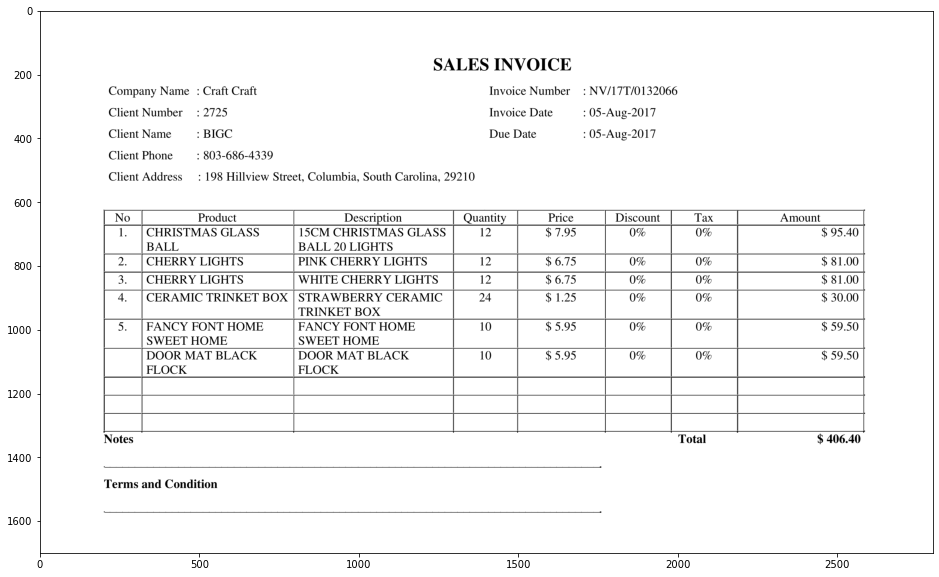

In [9]:
# Combine horizontal and vertical lines in a new third image, with both having same weight.
img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
#Eroding and thesholding the image
img_vh = cv2.erode(~img_vh, kernel, iterations=2)
thresh, img_vh = cv2.threshold(img_vh,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
bitxor = cv2.bitwise_xor(img,img_vh)
bitnot = cv2.bitwise_not(bitxor)
#Plotting the generated image
plt.figure(figsize=(16,12))
plotting = plt.imshow(bitnot,cmap='gray')
plt.show()

In [10]:
# Detect contours for following box detection
contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

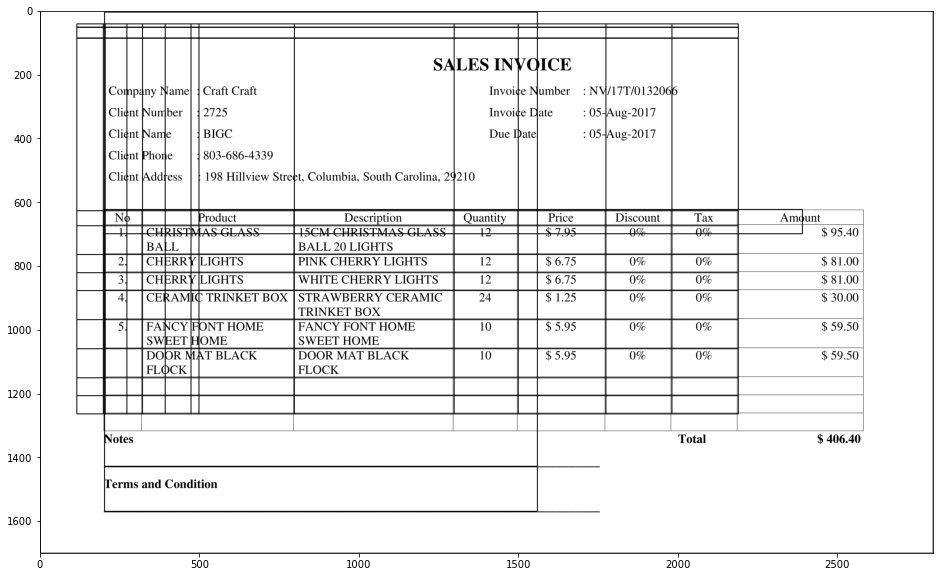

In [11]:
def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
    
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
        
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
        
    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

# Sort all the contours by top to bottom.
contours, boundingBoxes = sort_contours(contours, method="top-to-bottom")

img_copy = img.copy()
for x,y,x2,y2 in boundingBoxes:
    cv2.rectangle(img_copy, (x,y), (x2,y2), (0,255,0),2)
    
plt.figure(figsize=(16,12))
plt.imshow(img_copy,cmap='gray')

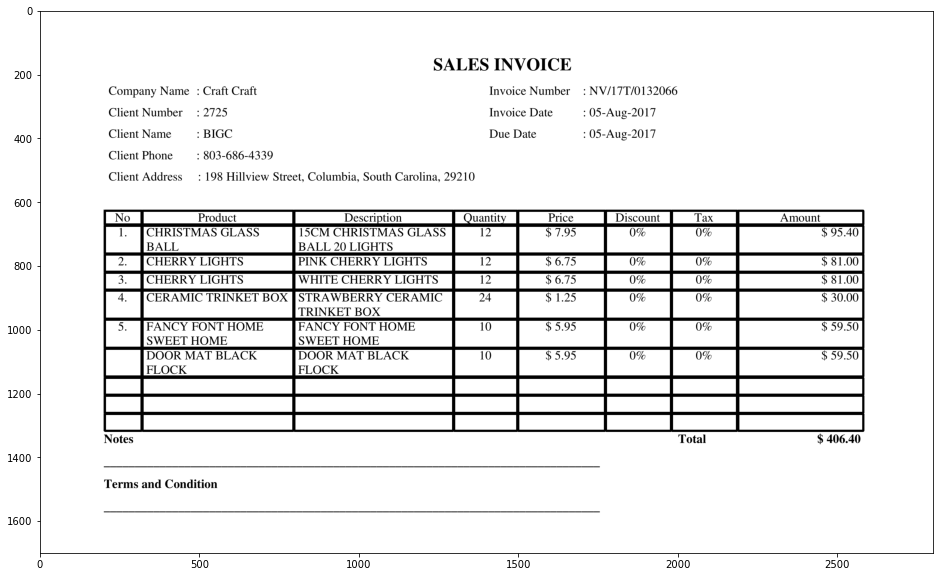

In [13]:
#Creating a list of heights for all detected boxes
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]
#Get mean of heights
mean = np.mean(heights)

#Create list box to store all boxes in  
box = []
# Get position (x,y), width and height for every contour and show the contour on image
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if (w<500 and h<500):
        image = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        box.append([x,y,w,h])

img_copy = img.copy()
for x,y,w,h in box:
    cv2.rectangle(img_copy, (x,y), (x+w,y+h), (0,255,0),5)

plt.figure(figsize=(16,12))
plt.imshow(img_copy,cmap='gray')

In [14]:
#Creating two lists to define row and column in which cell is located
row=[]
column=[]
j=0
#Sorting the boxes to their respective row and column
for i in range(len(box)):
    if(i==0):
        column.append(box[i])
        previous=box[i]
    else:
        if(box[i][1]<=previous[1]+mean/2):
            column.append(box[i])
            previous=box[i]
            if(i==len(box)-1):
                row.append(column)
        else:
            row.append(column)
            column=[]
            previous = box[i]
            column.append(box[i])

In [15]:
#calculating maximum number of cells
countcol = 0
for i in range(len(row)):
    countcol = len(row[i])
    if countcol > countcol:
        countcol = countcol

In [16]:
#Retrieving the center of each column
center = [int(row[i][j][0]+row[i][j][2]/2) for j in range(len(row[i])) if row[0]]
center=np.array(center)
center.sort()

In [17]:
#Regarding the distance to the columns center, the boxes are arranged in respective order
finalboxes = []
for i in range(len(row)):
    lis=[]
    for k in range(countcol):
        lis.append([])
    for j in range(len(row[i])):
        diff = abs(center-(row[i][j][0]+row[i][j][2]/4))
        minimum = min(diff)
        indexing = list(diff).index(minimum)
        lis[indexing].append(row[i][j])
    finalboxes.append(lis)

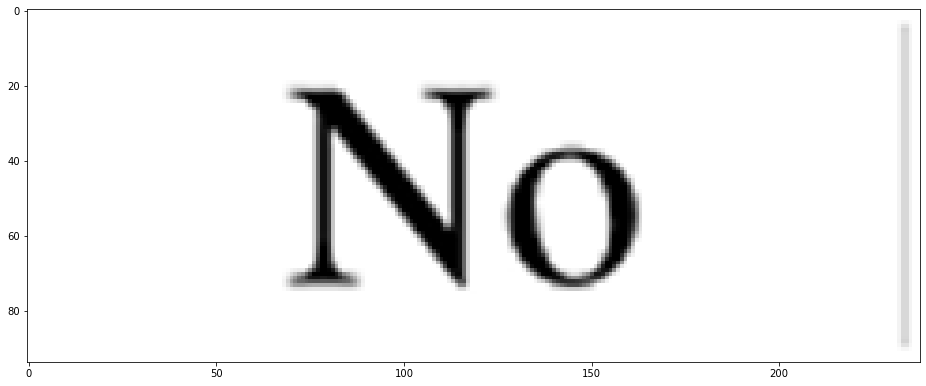

None


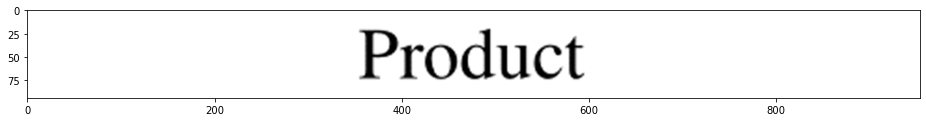

Product



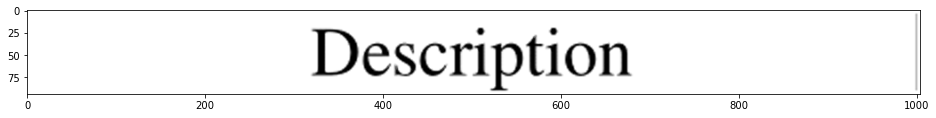

Description



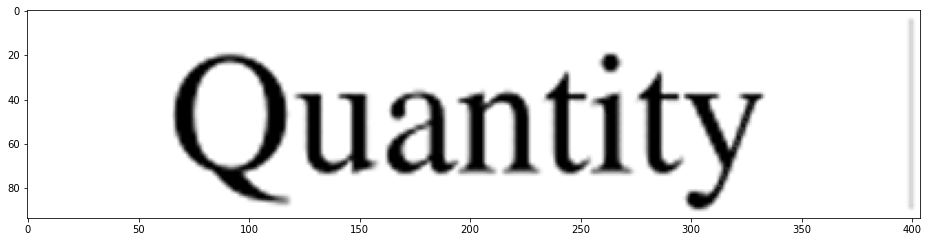

Ouantity



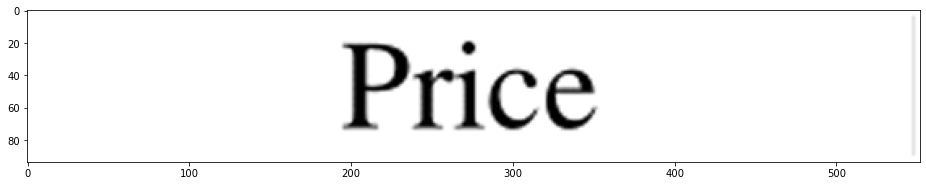

Price



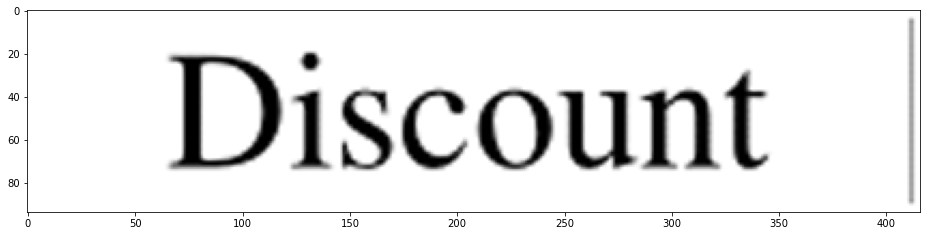

Discount



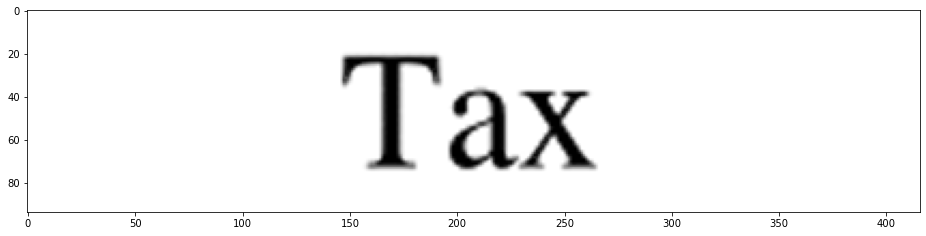

Tax



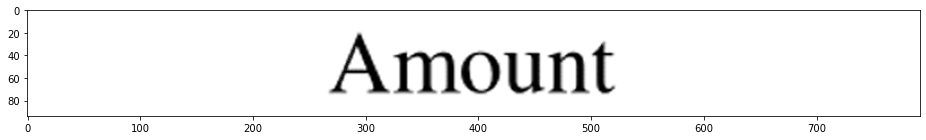

Amount



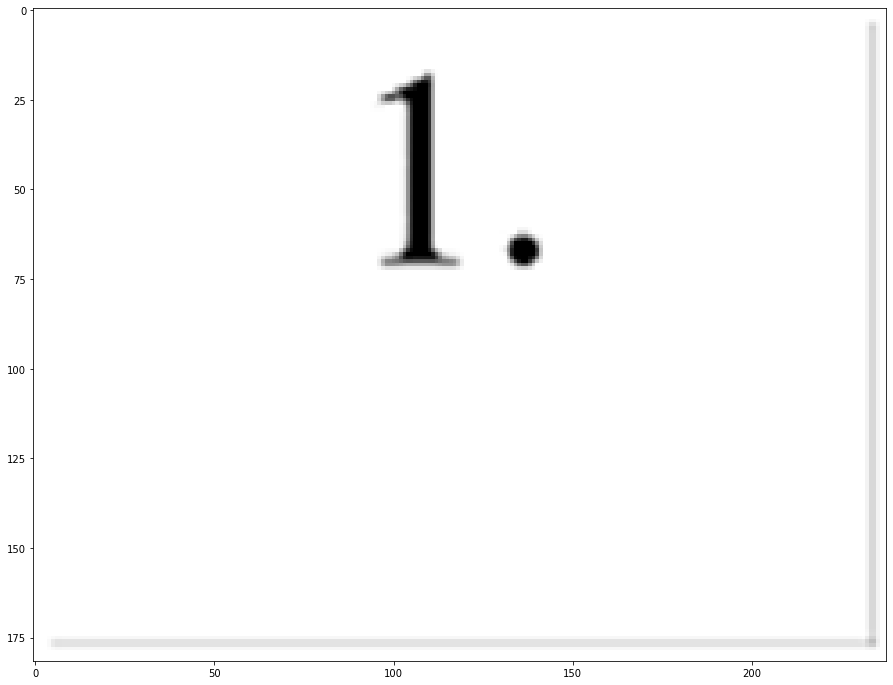

.



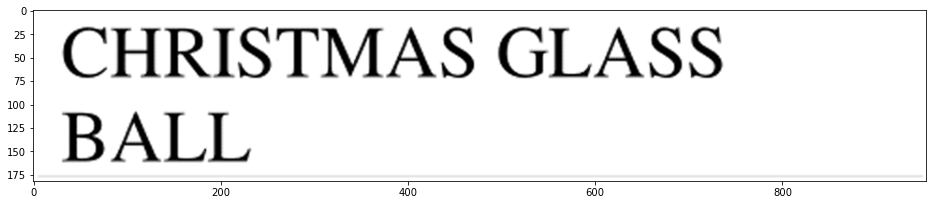

CHRISTMAS GLASS
BALL



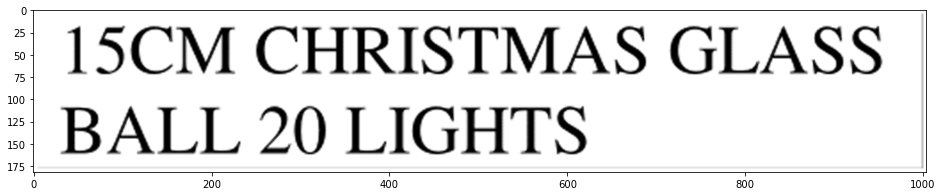

15SCM CHRISTMAS GLASS
BALL 20 LIGHTS



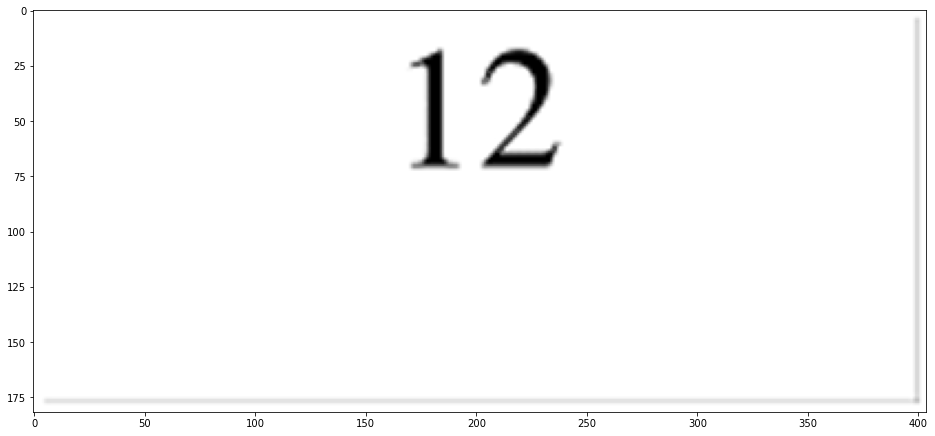

12



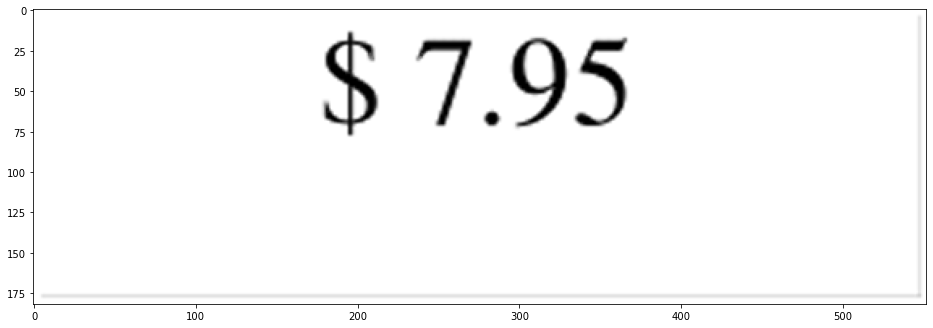

$ 7.95



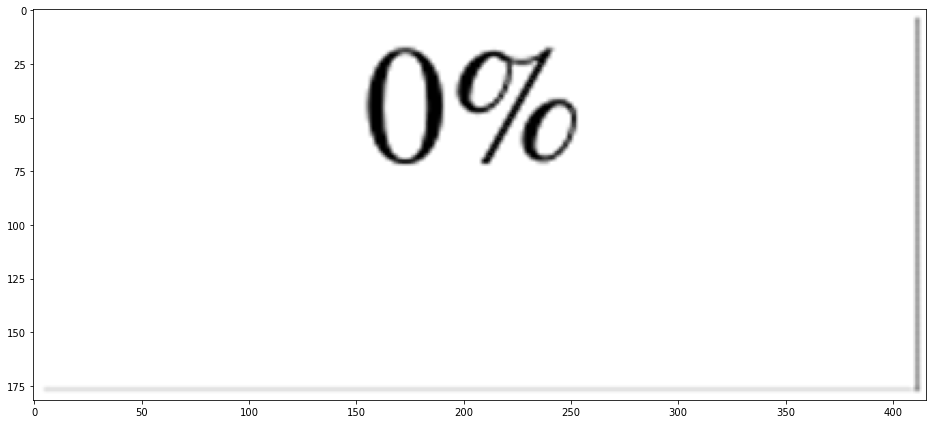

090



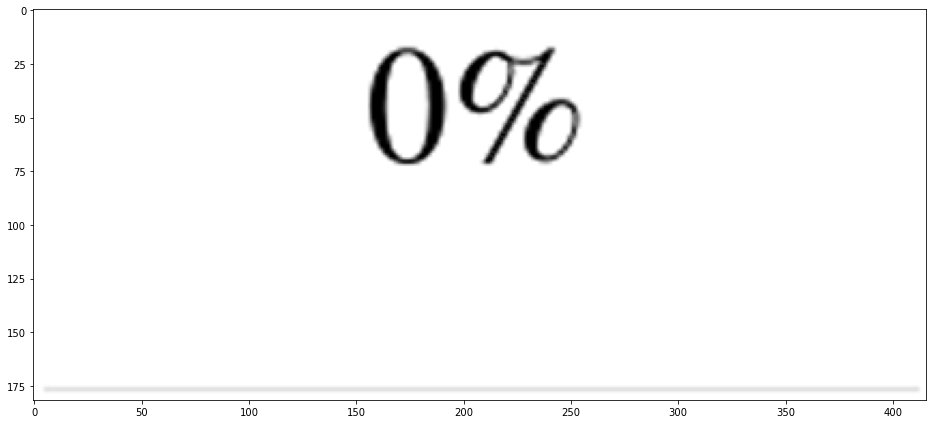

090



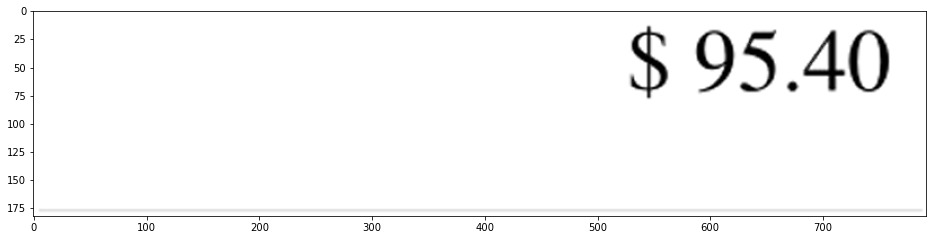

$ 95.40



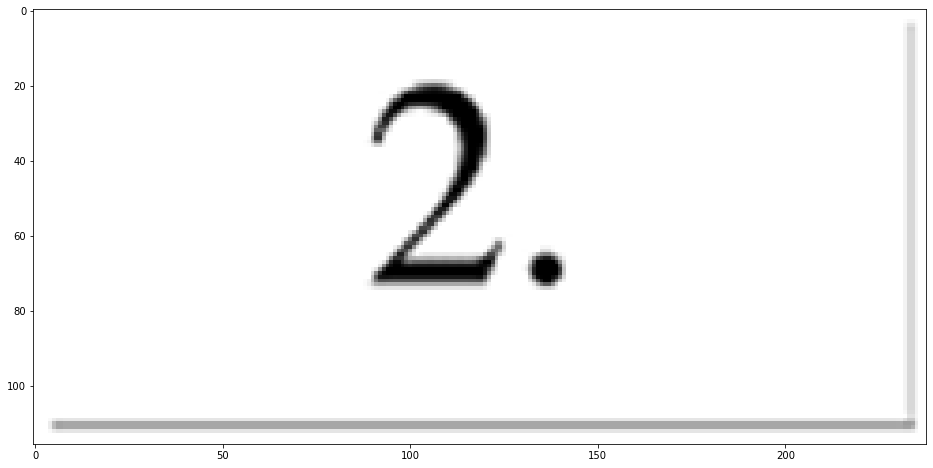

2.



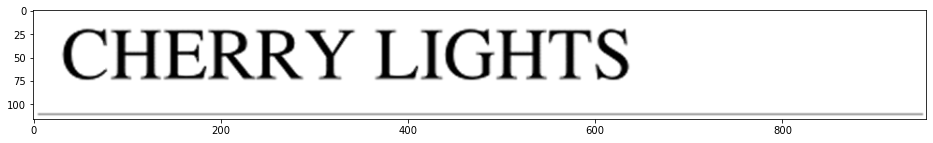

CHERRY LIGHTS



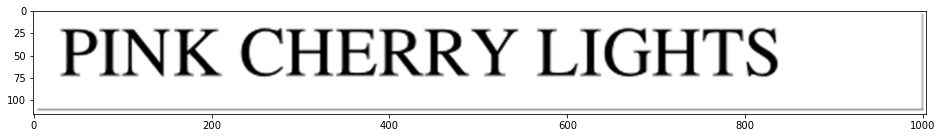

PINK CHERRY LIGHTS



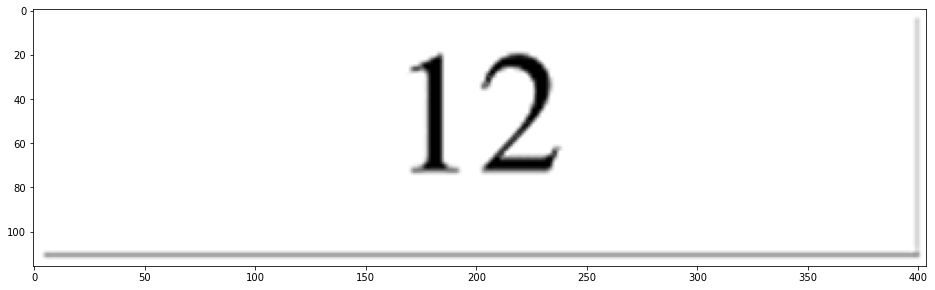

12



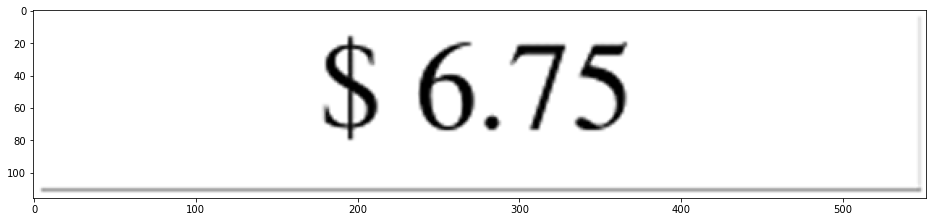

$ 6.75



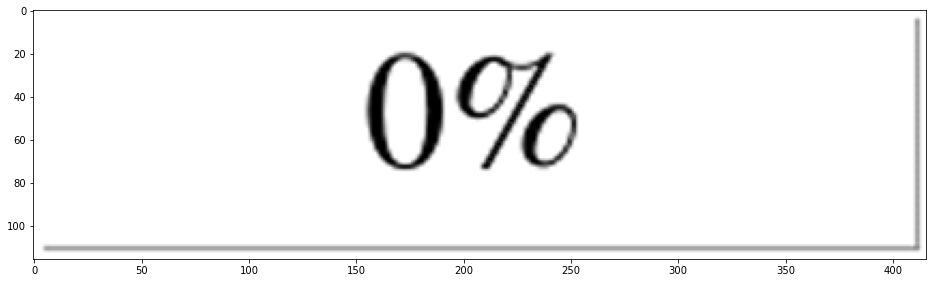

090



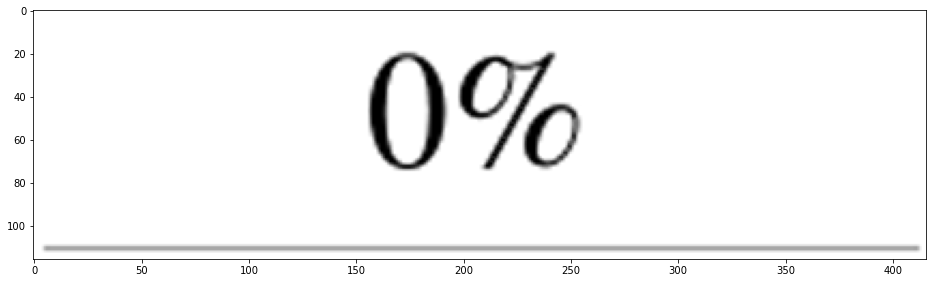

090



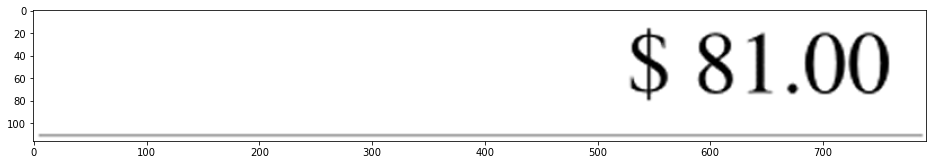

$ 81.00



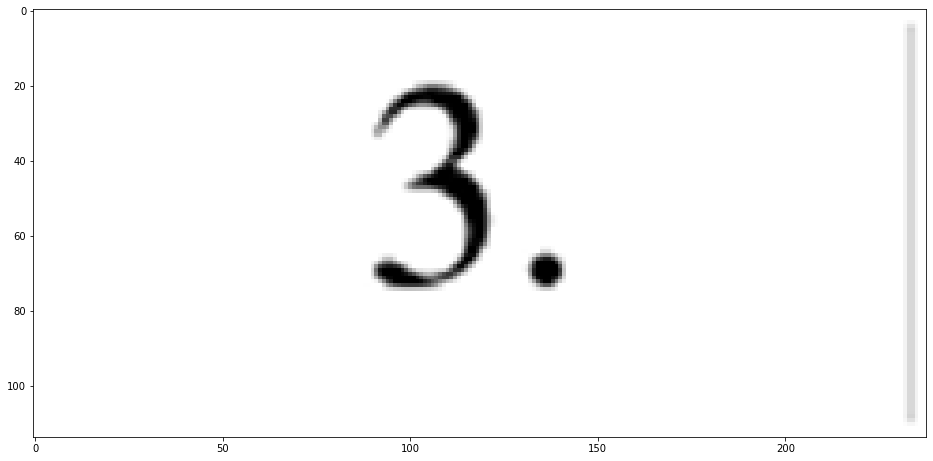

3.



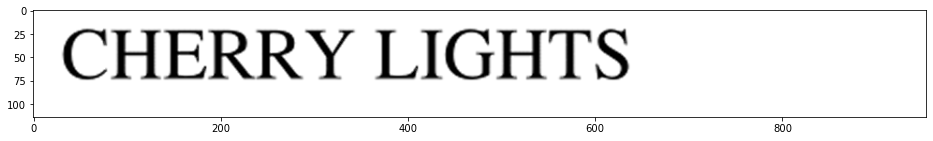

CHERRY LIGHTS



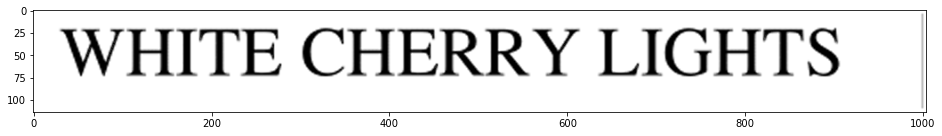

WHITE CHERRY LIGHTS



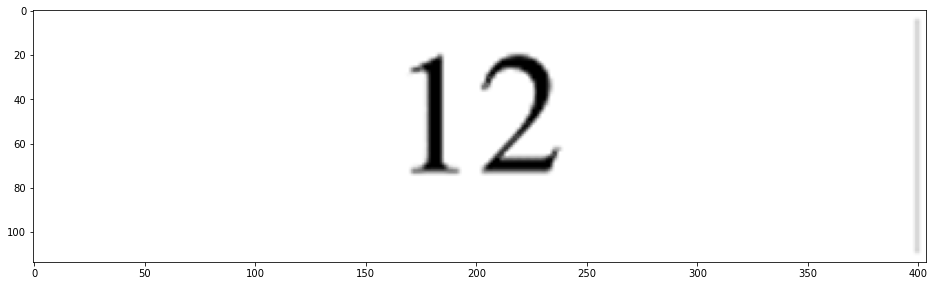

12



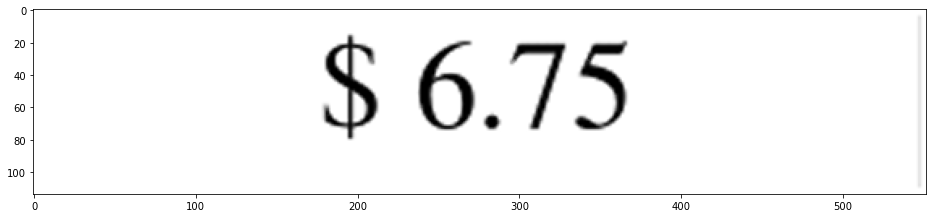

$ 6.75



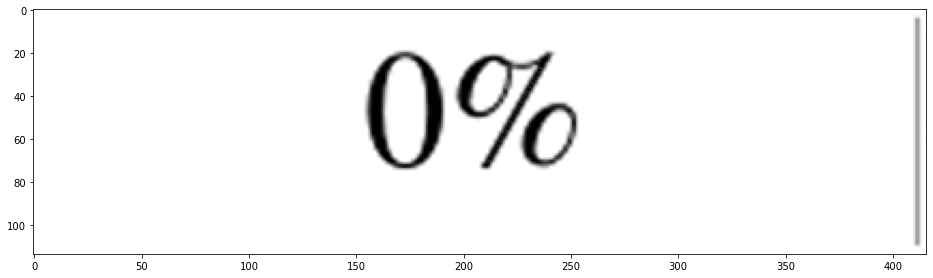

090



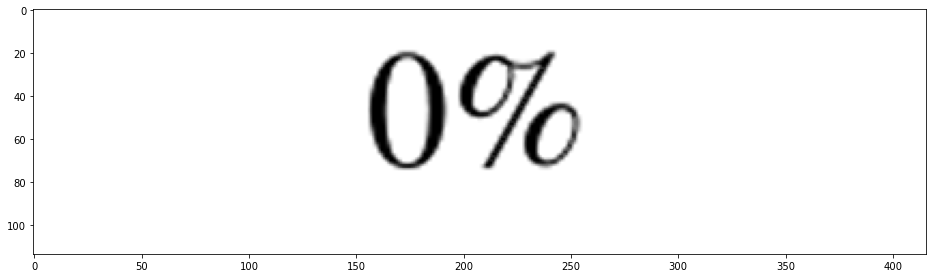

090



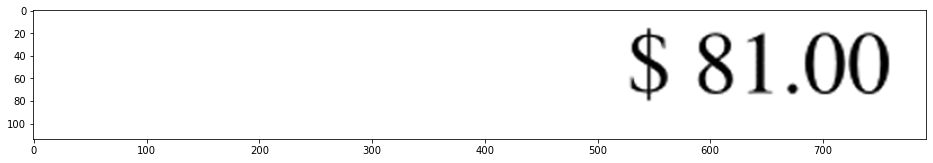

$ 81.00



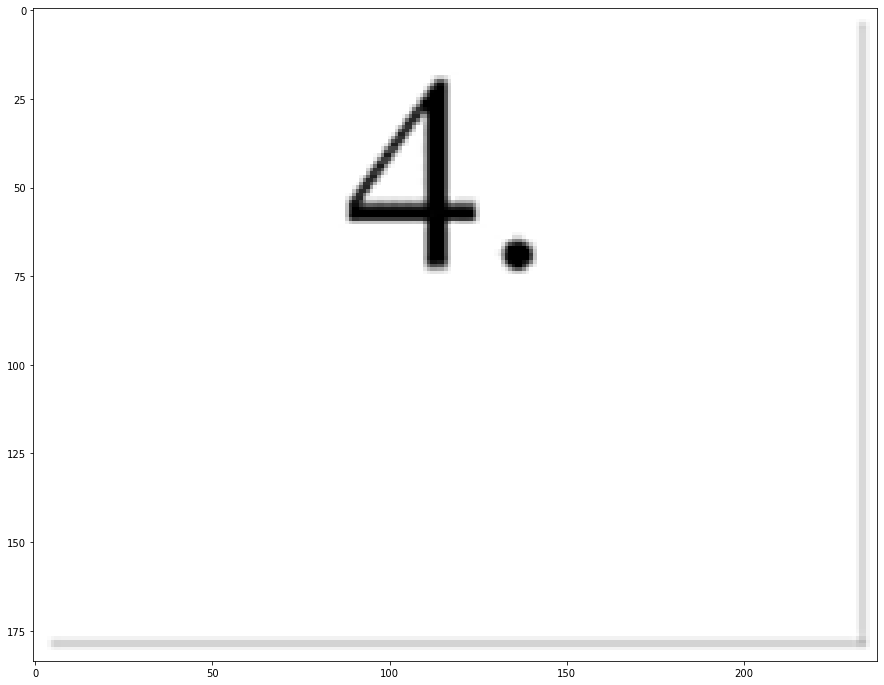

4.



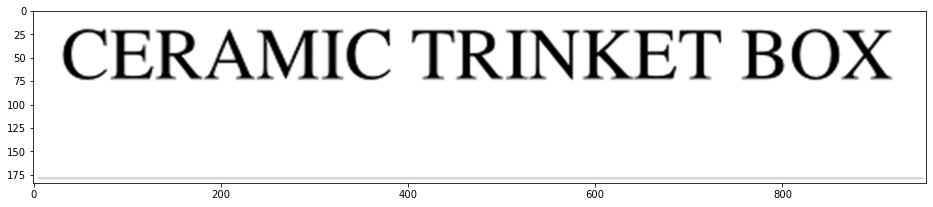

CERAMIC TRINKET BOX



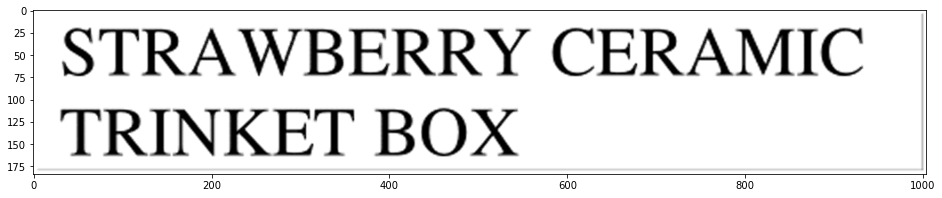

STRAWBERRY CERAMIC
TRINKET BOX



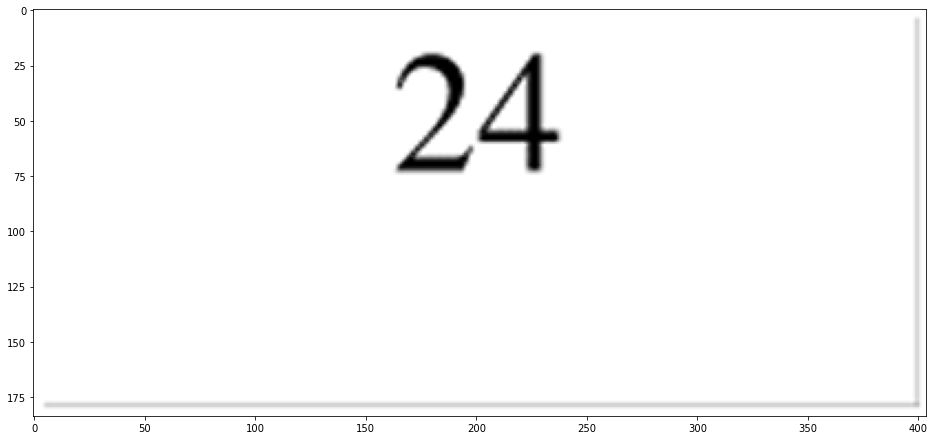

24



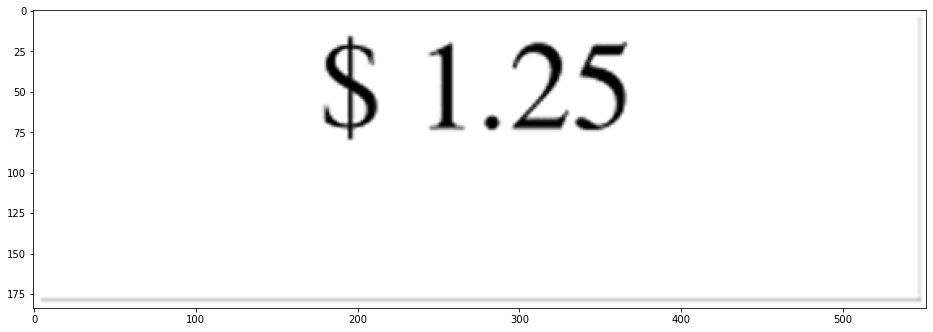

$ 1.25



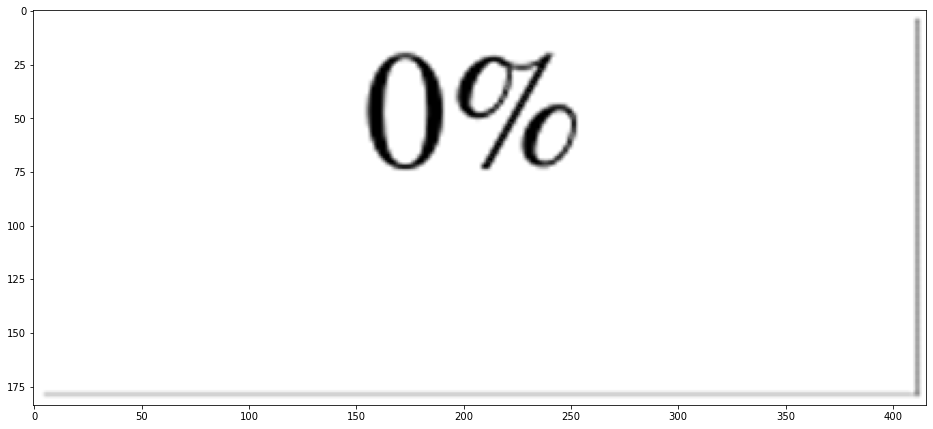

090



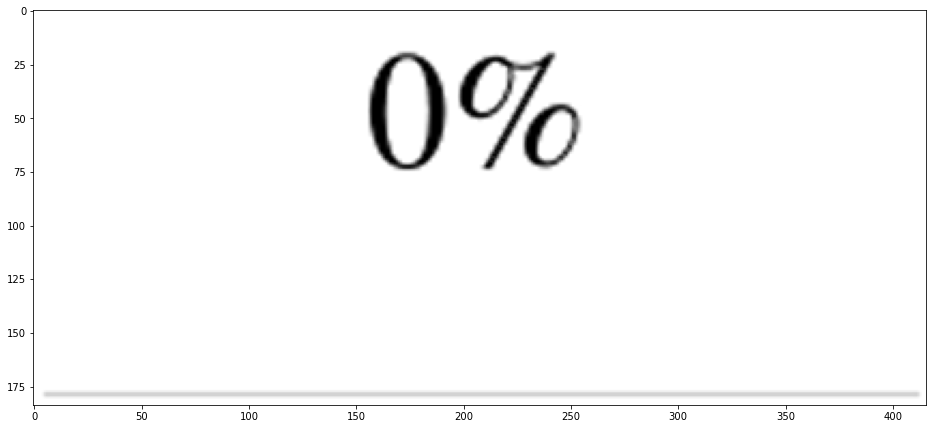

090



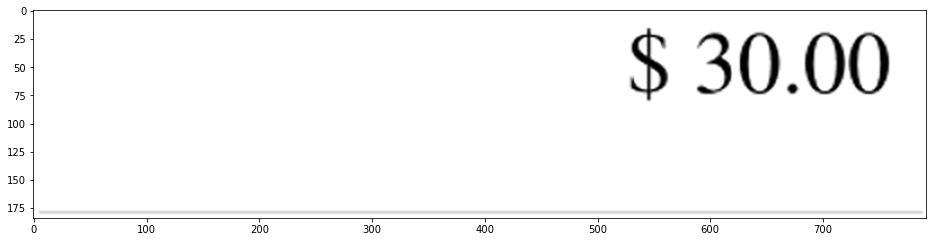

$ 30.00



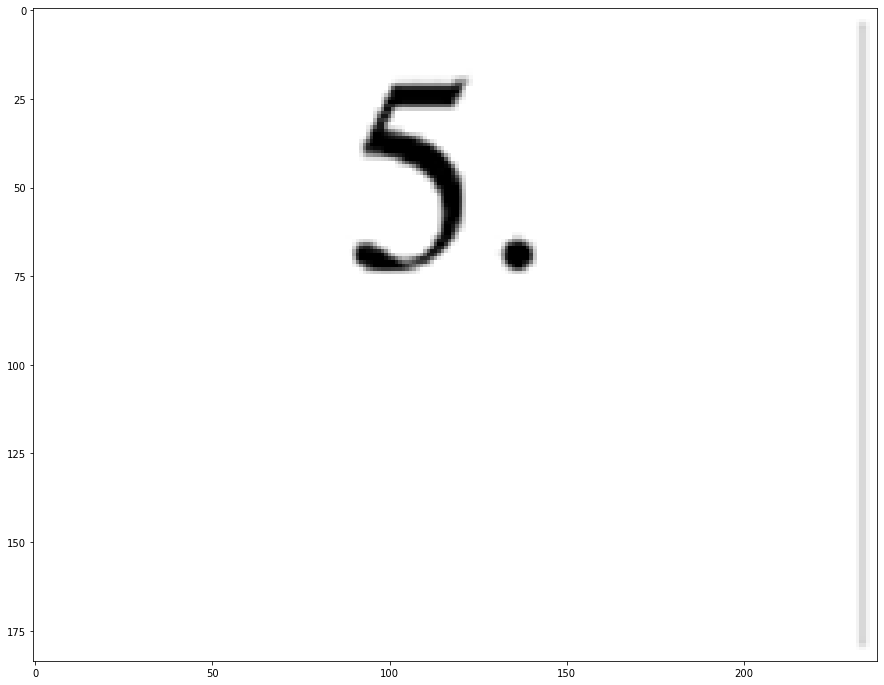

5.



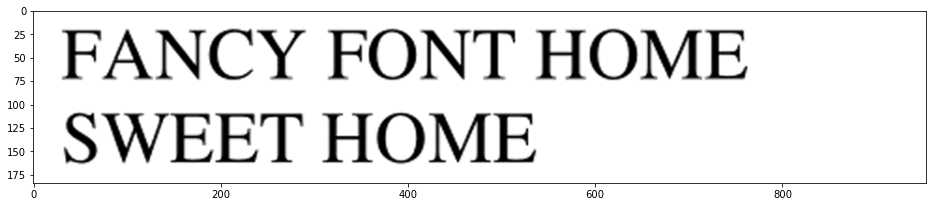

FANCY FONT HOME
SWEET HOME



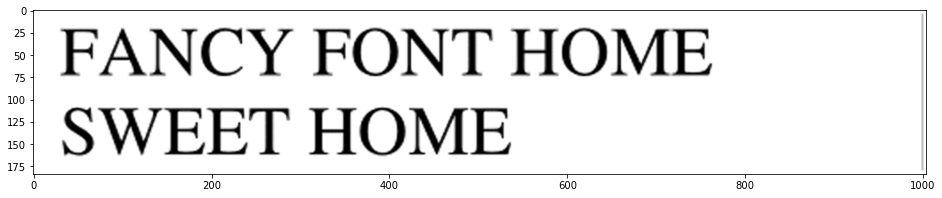

FANCY FONT HOME
SWEET HOME



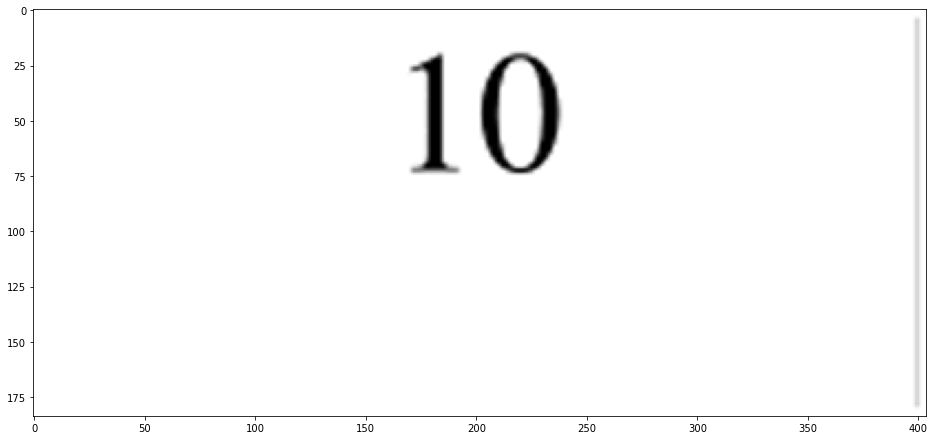

10



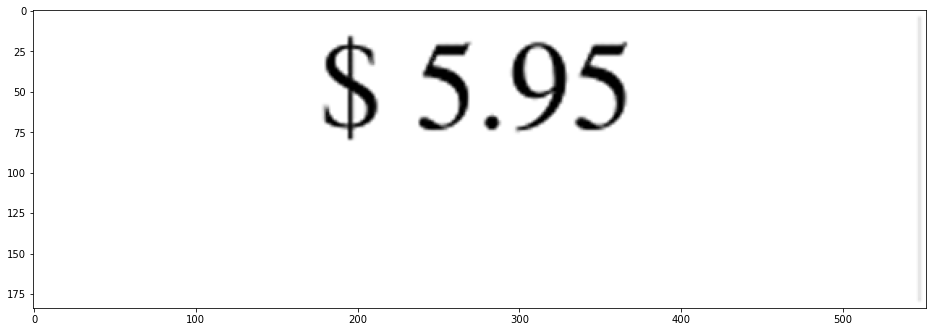

$ 5.95



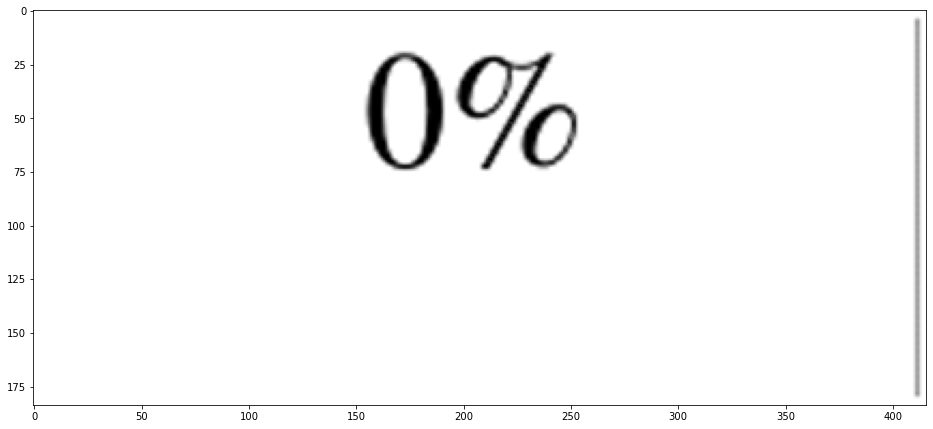

090



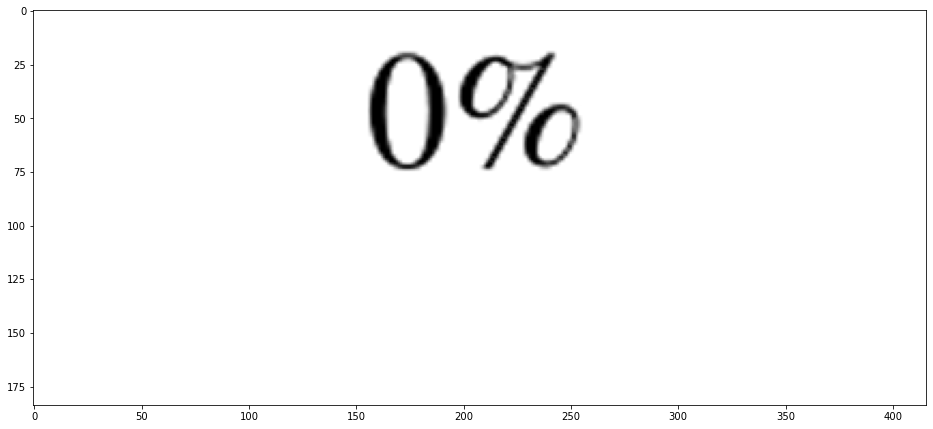

090



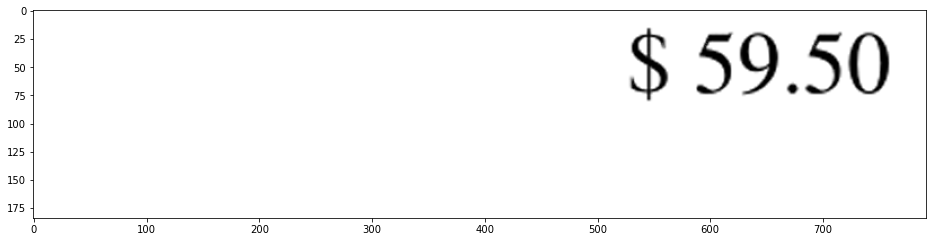

$ 59.50



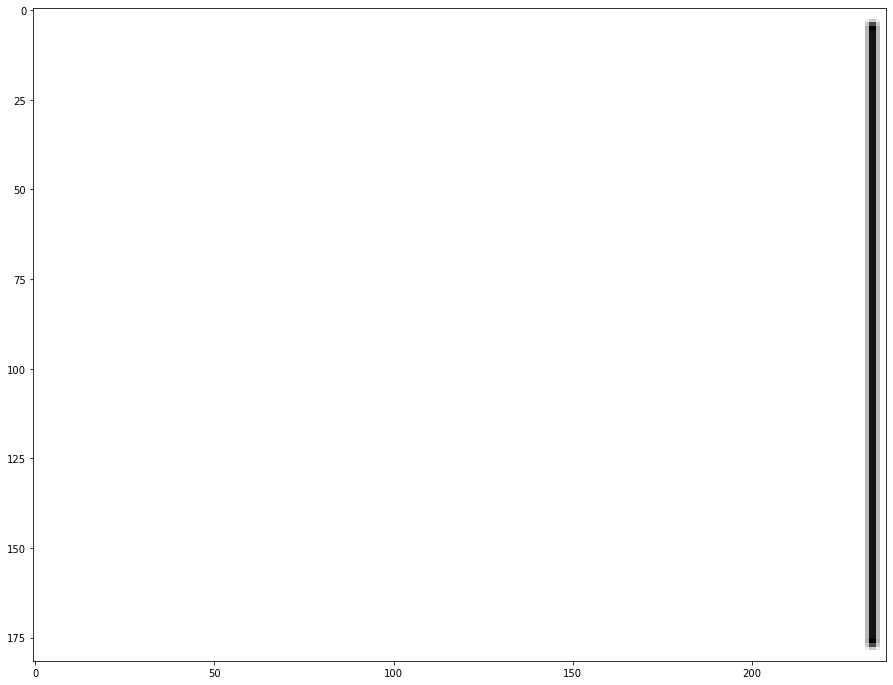

None


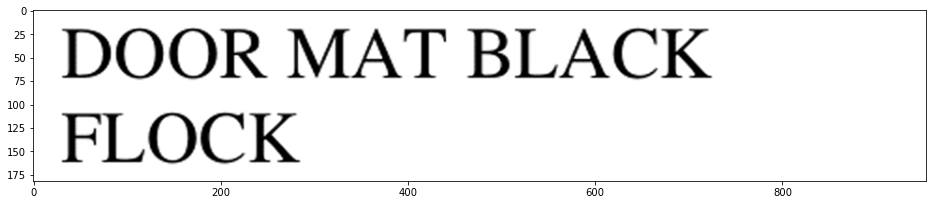

DOOR MAT BLACK
FLOCK



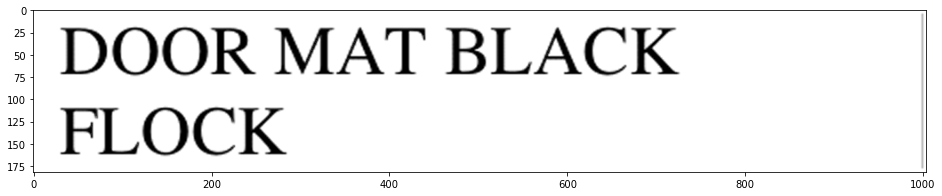

DOOR MAT BLACK
FLOCK



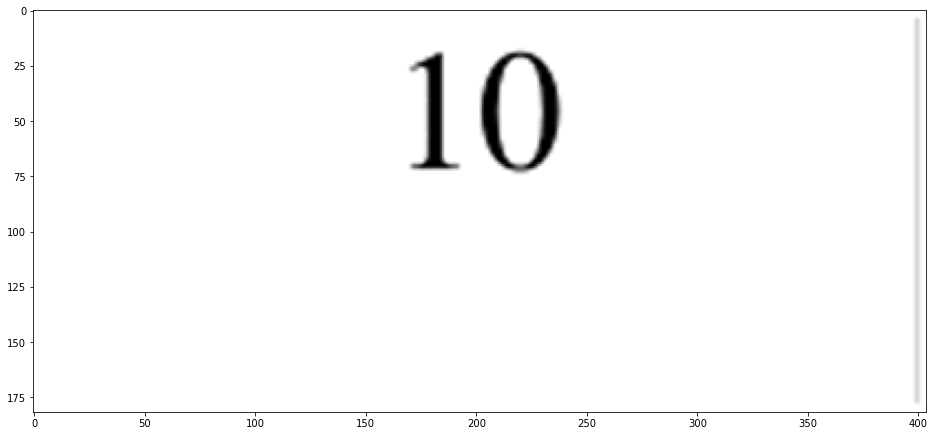

10



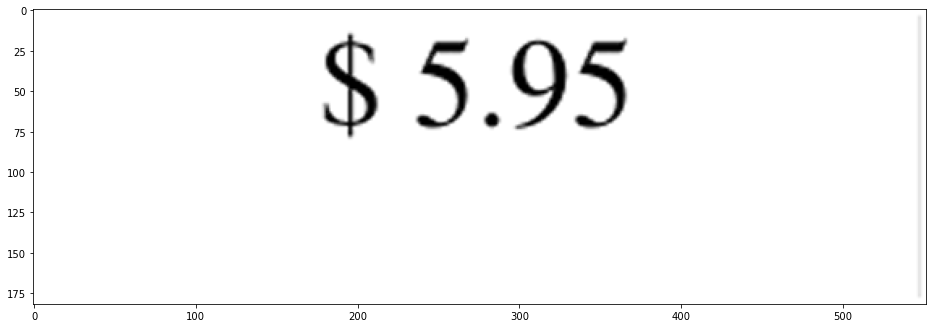

$ 5.95



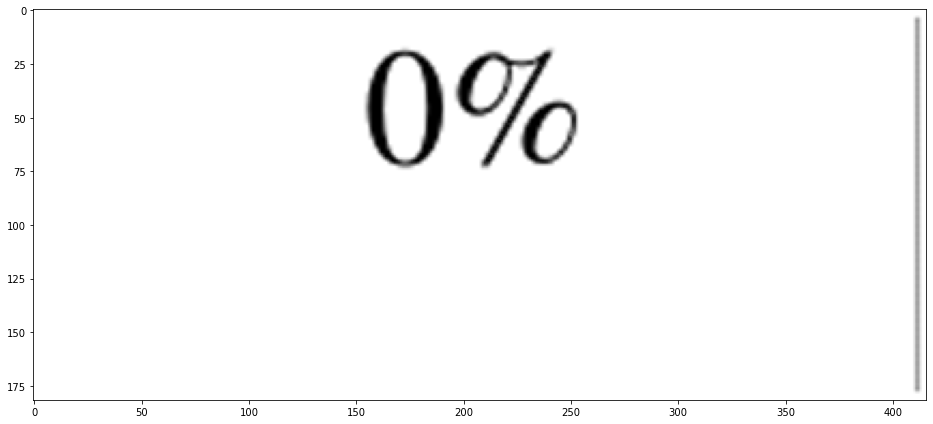

090



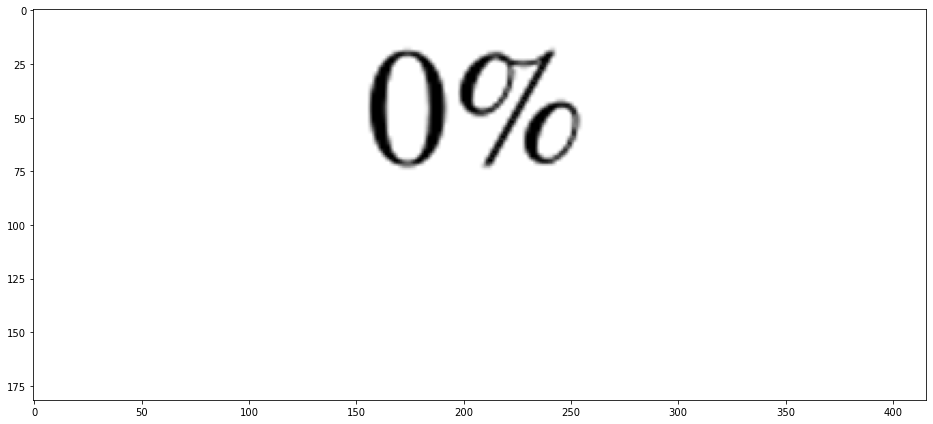

090



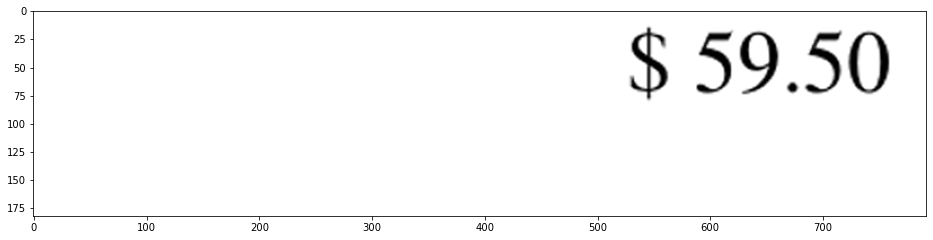

$ 59.50



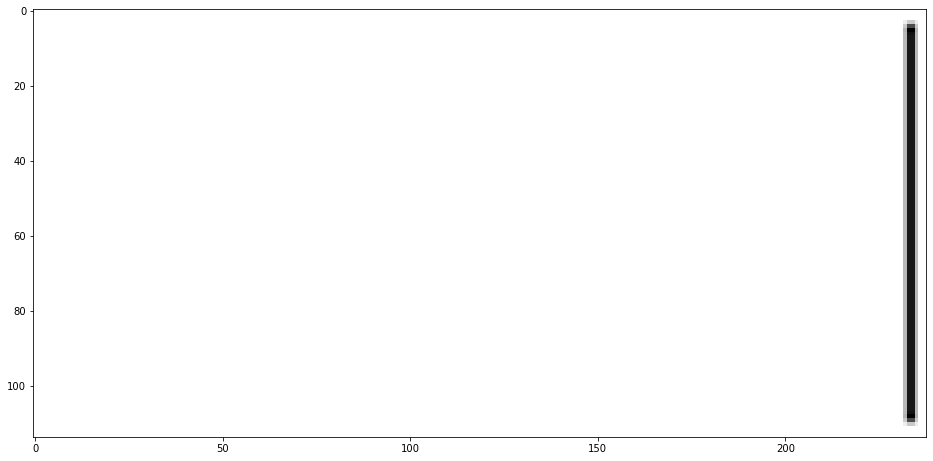

None


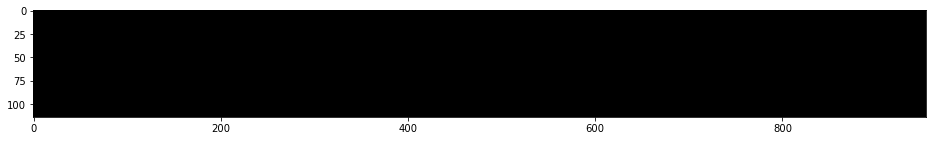

None


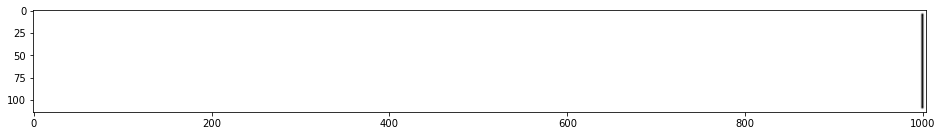

None


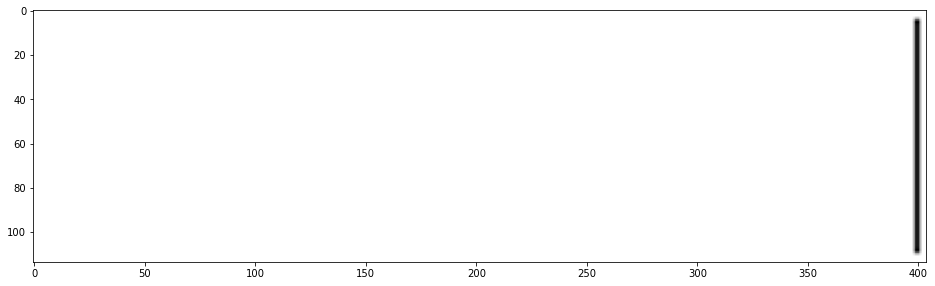

None


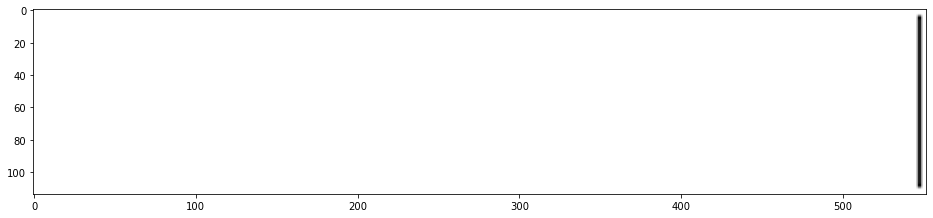

None


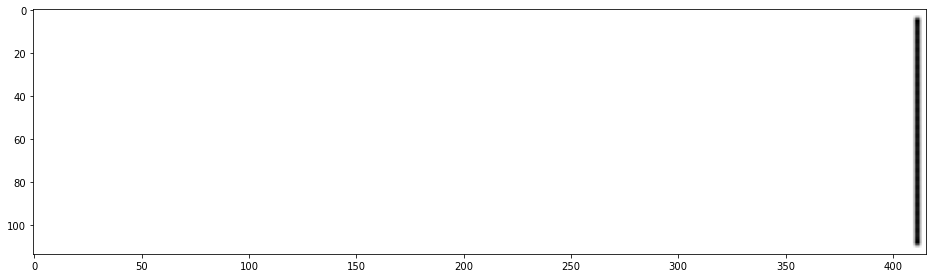

None


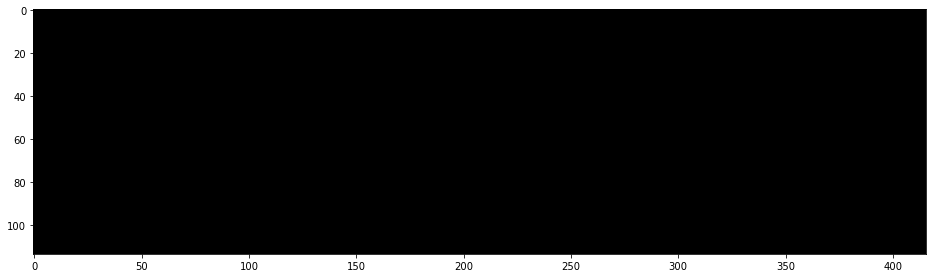

None


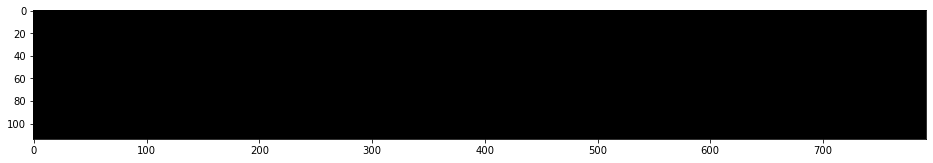

None


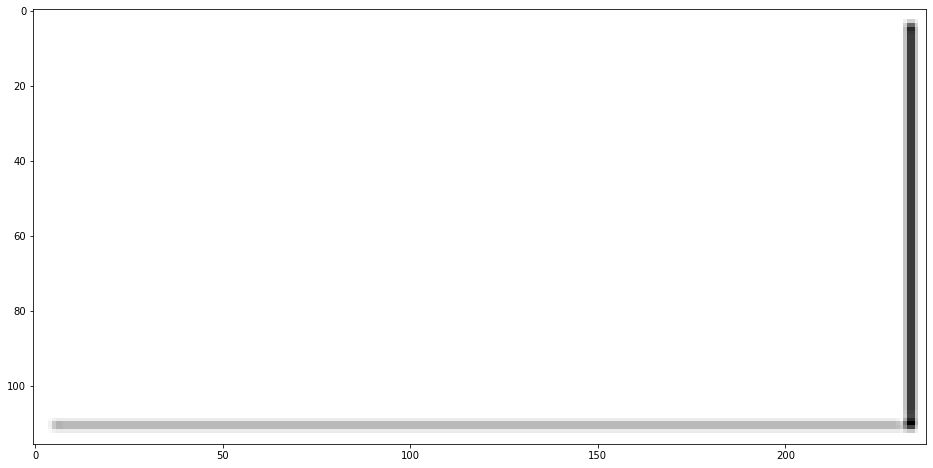

None


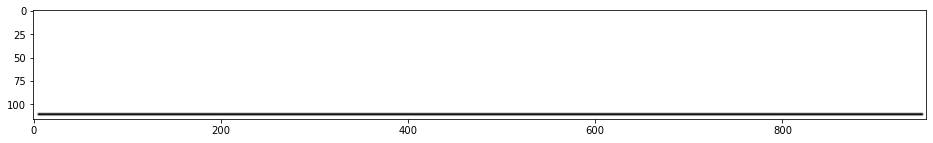

None


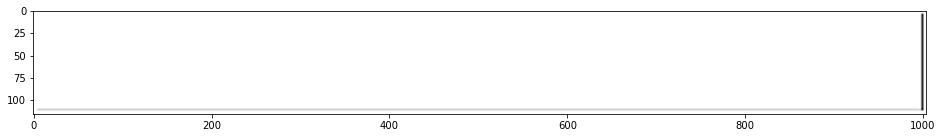

None


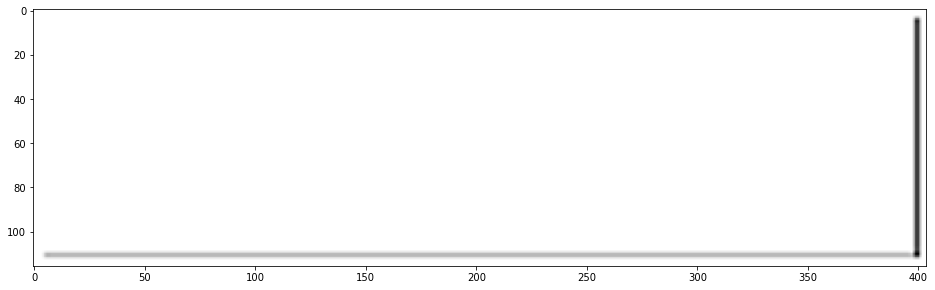

None


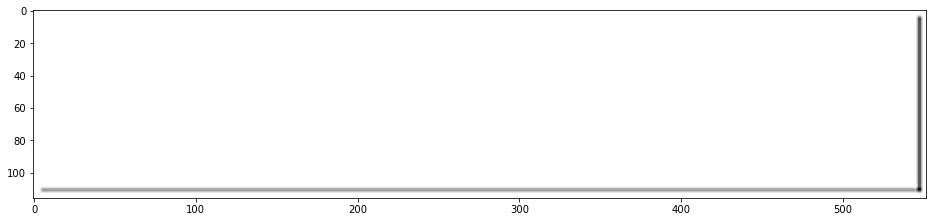

None


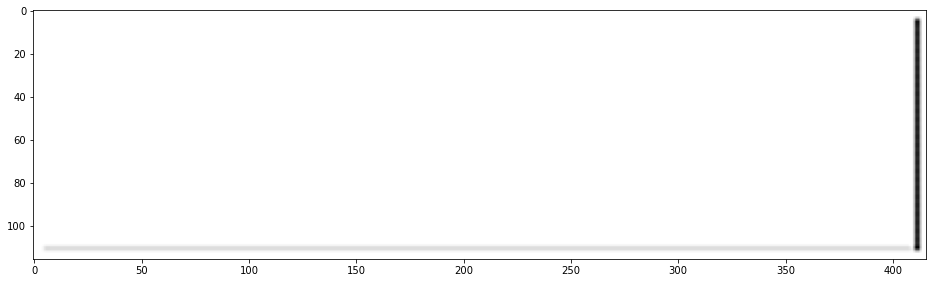

None


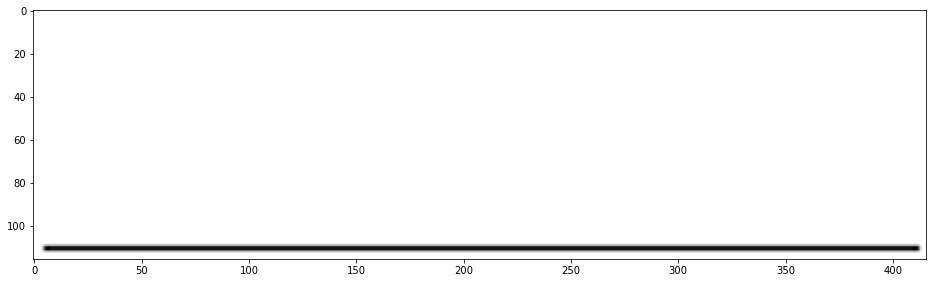

None


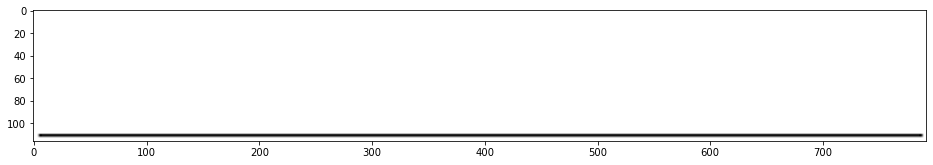

None


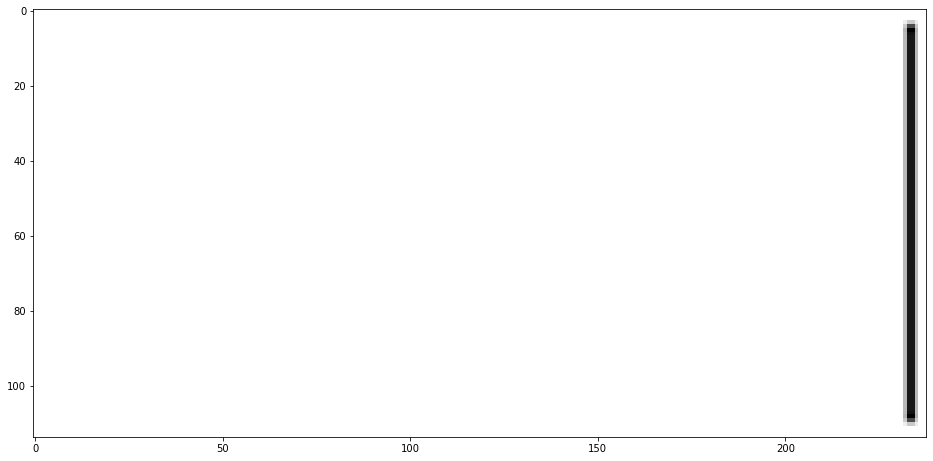

None


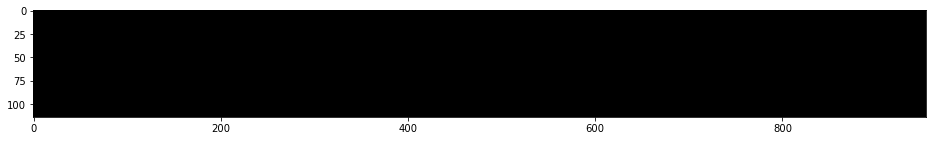

None


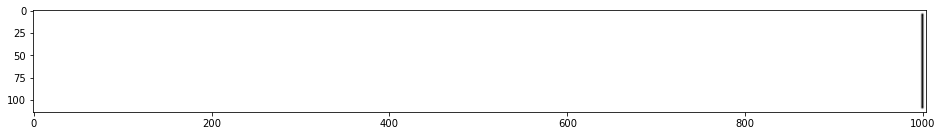

None


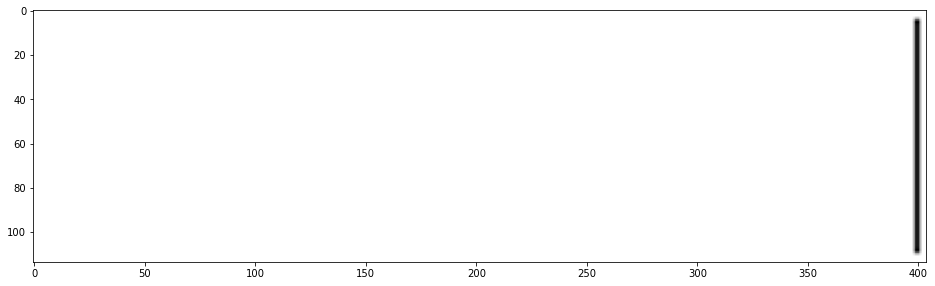

None


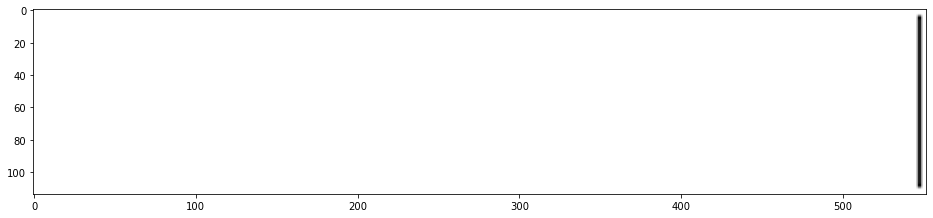

None


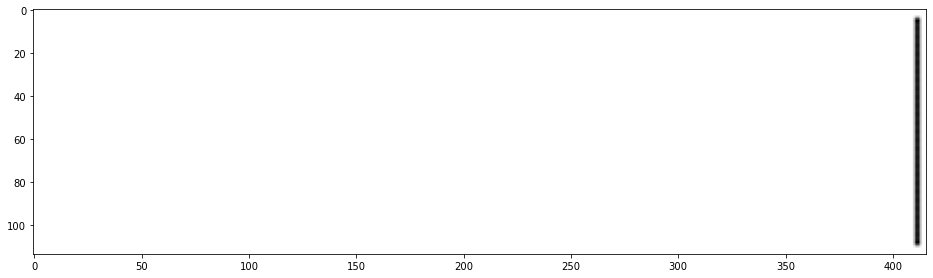

None


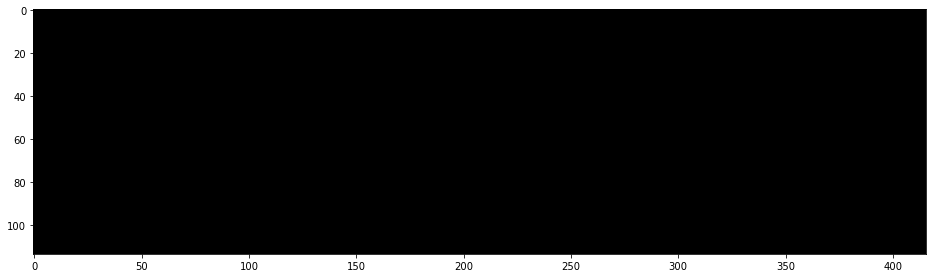

None


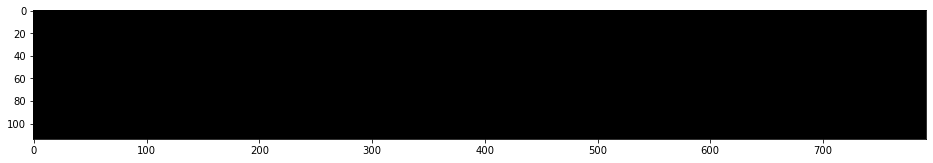

None


In [21]:
#from every single image-based cell/box the strings are extracted via pytesseract and stored in a list
outer=[]
for i in range(len(finalboxes)):
    for j in range(len(finalboxes[i])):
        out=''
        if(len(finalboxes[i][j])==0):
            outer.append(' ')
        else:
            for k in range(len(finalboxes[i][j])):
                y,x,w,h = finalboxes[i][j][k][0],finalboxes[i][j][k][1], finalboxes[i][j][k][2],finalboxes[i][j][k][3]
                finalimg = bitnot[x:x+h, y:y+w]
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                border = cv2.copyMakeBorder(finalimg,2,2,2,2,   cv2.BORDER_CONSTANT,value=[255,255])
                resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                dilation = cv2.dilate(resizing, kernel,iterations=1)
                erosion = cv2.erode(dilation, kernel,iterations=1)
                
                plt.figure(figsize=(16,12))
                plotting = plt.imshow(erosion,cmap='gray')
                plt.show()
                
                out = pytesseract.image_to_string(erosion, lang="ind")
                
                if(len(out)==0):
                    out = pytesseract.image_to_string(erosion, config= '--psm 6 digits')
                
                if(out == ""):
                    out = None
                    
                print(out)
                
            outer.append(out)

In [27]:
import pandas as pd

#Creating a dataframe of the generated OCR list
arr = np.array(outer)
goods = pd.DataFrame(arr.reshape(len(row),countcol))
goods

,0,1,2,3,4,5,6,7
0,None,Product\n,Description\n,Ouantity\n,Price\n,Discount\n,Tax\n,Amount\n
1,.\n,CHRISTMAS GLASS\nBALL\n,15SCM CHRISTMAS GLASS\nBALL 20 LIGHTS\n,12\n,$ 7.95\n,090\n,090\n,$ 95.40\n
2,2.\n,CHERRY LIGHTS\n,PINK CHERRY LIGHTS\n,12\n,$ 6.75\n,090\n,090\n,$ 81.00\n
3,3.\n,CHERRY LIGHTS\n,WHITE CHERRY LIGHTS\n,12\n,$ 6.75\n,090\n,090\n,$ 81.00\n
4,4.\n,CERAMIC TRINKET BOX\n,STRAWBERRY CERAMIC\nTRINKET BOX\n,24\n,$ 1.25\n,090\n,090\n,$ 30.00\n
5,5.\n,FANCY FONT HOME\nSWEET HOME\n,FANCY FONT HOME\nSWEET HOME\n,10\n,$ 5.95\n,090\n,090\n,$ 59.50\n
6,None,DOOR MAT BLACK\nFLOCK\n,DOOR MAT BLACK\nFLOCK\n,10\n,$ 5.95\n,090\n,090\n,$ 59.50\n
7,None,None,None,None,None,None,None,None
8,None,None,None,None,None,None,None,None
9,None,None,None,None,None,None,None,None


In [28]:
goods = goods.replace('\n',' ', regex=True)
goods

,0,1,2,3,4,5,6,7
0,None,Product,Description,Ouantity,Price,Discount,Tax,Amount
1,.,CHRISTMAS GLASS BALL,15SCM CHRISTMAS GLASS BALL 20 LIGHTS,12,$ 7.95,090,090,$ 95.40
2,2.,CHERRY LIGHTS,PINK CHERRY LIGHTS,12,$ 6.75,090,090,$ 81.00
3,3.,CHERRY LIGHTS,WHITE CHERRY LIGHTS,12,$ 6.75,090,090,$ 81.00
4,4.,CERAMIC TRINKET BOX,STRAWBERRY CERAMIC TRINKET BOX,24,$ 1.25,090,090,$ 30.00
5,5.,FANCY FONT HOME SWEET HOME,FANCY FONT HOME SWEET HOME,10,$ 5.95,090,090,$ 59.50
6,None,DOOR MAT BLACK FLOCK,DOOR MAT BLACK FLOCK,10,$ 5.95,090,090,$ 59.50
7,None,None,None,None,None,None,None,None
8,None,None,None,None,None,None,None,None
9,None,None,None,None,None,None,None,None


In [29]:
goods = goods.dropna(how="all")
goods

,0,1,2,3,4,5,6,7
0,None,Product,Description,Ouantity,Price,Discount,Tax,Amount
1,.,CHRISTMAS GLASS BALL,15SCM CHRISTMAS GLASS BALL 20 LIGHTS,12,$ 7.95,090,090,$ 95.40
2,2.,CHERRY LIGHTS,PINK CHERRY LIGHTS,12,$ 6.75,090,090,$ 81.00
3,3.,CHERRY LIGHTS,WHITE CHERRY LIGHTS,12,$ 6.75,090,090,$ 81.00
4,4.,CERAMIC TRINKET BOX,STRAWBERRY CERAMIC TRINKET BOX,24,$ 1.25,090,090,$ 30.00
5,5.,FANCY FONT HOME SWEET HOME,FANCY FONT HOME SWEET HOME,10,$ 5.95,090,090,$ 59.50
6,None,DOOR MAT BLACK FLOCK,DOOR MAT BLACK FLOCK,10,$ 5.95,090,090,$ 59.50


In [30]:
txt = pytesseract.image_to_string(img_bin, lang="ind") 
print(txt)

SALES INVOICE

Company Name : Craft Craft Invoice Number : NV/17T/0132066
Client Number :2725 Invoice Date : 0S-Aug-2017
Client Name : BIGC Due Date : 0S-Aug-2017

Client Phone : 803-686-4339
Client Address : 198 Hillview Street, Columbia, South Carolina, 29210

No Product Description Ouantity Price Discount Tax Amount
1. . CHRISTMAS GLASS 15CM CHRISTMAS GLASS 12 $7.95 090 090 $ 95.40
BALL BALL 20 LIGHTS
. | CHERRY LIGHTS PINK CHERRY LIGHTS 12 $6.75 090 090 $ 81.00
3. . CHERRY LIGHTS WHITE CHERRY LIGHTS 12 $6.75 090 090 $ 81.00
CERAMIC TRINKET BOX STRAWBERRY CERAMIC 24 $1.25 090 090 $ 30.00
TRINKET BOX
5. . FANCY FONT HOME FANCY FONT HOME 10 $ 5.95 090 090 $ 59.50
SWEET HOME SWEET HOME
DOOR MAT BLACK DOOR MAT BLACK 10 $ 5.95 090 090 $ 59.50
FLOCK FLOCK
Notes Total $ 406.40

Terms and Condition



In [31]:
def define_result():
    result = {
        'Invoice Number': '0',
        'Invoice Date': '0',
        'Due Date': '0',
        'Company Name': '0',
        'Client Number': '0',
        'Client Name': '0',
        'Client Phone': '0',
        'Client Address': '0',
        'Amount of goods': '0',
        'Goods': '0',
        'Total': '0',
        'Notes': '0',
        'Terms and Condition': '0'}
    
    return result

In [32]:
def extract(extracted_result):
    result = define_result()
    
    for word in extracted_result.split("\n"):
        if 'Company' in word or 'Invoice Number' in word:
            word = word.replace('Company Name','')
            word = word.replace('Invoice Number','')
            word = word.split(':')
            
            word = [x for x in word if x != ' ']
            
            
            result['Company Name'] = word[0]
            result['Invoice Number'] = word[1]
        
        elif 'Client Number' in word or 'Invoice Date' in word:
            word = word.replace('Client Number','')
            word = word.replace('Invoice Date','')
            word = word.split(':')
            
            word = [x for x in word if x != ' ']
            
            result['Client Number'] = word[0]
            result['Invoice Date'] = word[1]
            
        elif 'Client Name' in word or 'Due Date' in word:
            word = word.replace('Client Name','')
            word = word.replace('Due Date','')
            word = word.split(':')
            
            word = [x for x in word if x != ' ']
            
            result['Client Name'] = word[0]
            result['Due Date'] = word[1]
            
        elif 'Client Phone' in word:
            word = word.replace('Client Phone','')
            word = word.split(':')
            
            word = [x for x in word if x != ' ']
            
            result['Client Phone'] = word[0]
        
        elif 'Client Address' in word:
            word = word.replace('Client Address','')
            word = word.split(':')
            
            word = [x for x in word if x != ' ']
            
            result['Client Address'] = word[0]
            
        elif 'Total' in word:
            word = word.replace('Notes','')
            word = word.replace('Total','')
            word = word.split(':')
            
            word = [x for x in word if x != ' ']
            
            result['Total'] = word[-1]
    
    result['Amount of goods'] = len(goods)
    return result
            
            

In [33]:
result = extract(txt)
result

{'Invoice Number': ' NV/17T/0132066',
 'Invoice Date': ' 0S-Aug-2017',
 'Due Date': ' 0S-Aug-2017',
 'Company Name': ' Craft Craft  ',
 'Client Number': '2725  ',
 'Client Name': ' BIGC  ',
 'Client Phone': ' 803-686-4339',
 'Client Address': ' 198 Hillview Street, Columbia, South Carolina, 29210',
 'Amount of goods': 7,
 'Goods': '0',
 'Total': '  $ 406.40',
 'Notes': '0',
 'Terms and Condition': '0'}

In [35]:
output = pd.DataFrame(result, index=[0])
output

,Invoice Number,Invoice Date,Due Date,Company Name,Client Number,Client Name,Client Phone,Client Address,Amount of goods,Goods,Total,Notes,Terms and Condition
0,NV/17T/0132066,0S-Aug-2017,0S-Aug-2017,Craft Craft,2725,BIGC,803-686-4339,"198 Hillview Street, Columbia, South Carolina...",7,0,$ 406.40,0,0


In [36]:
output['Goods'][len(output)-1] = goods.apply(lambda r: tuple(r), axis=1).apply(np.array)
output

C:\Users\Hanun\AppData\Local\Temp\ipykernel_12736\3105698784.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output['Goods'][len(output)-1] = goods.apply(lambda r: tuple(r), axis=1).apply(np.array)


,Invoice Number,Invoice Date,Due Date,Company Name,Client Number,Client Name,Client Phone,Client Address,Amount of goods,Goods,Total,Notes,Terms and Condition
0,NV/17T/0132066,0S-Aug-2017,0S-Aug-2017,Craft Craft,2725,BIGC,803-686-4339,"198 Hillview Street, Columbia, South Carolina...",7,"0 [None, Product , Description , Ouantity ,...",$ 406.40,0,0
